In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np 
import pandas as pd
import os

import lightgbm as lgb

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
sns.set(font_scale=1)
#os.chdir('/Users/hanbosun/Documents/GitHub/TrasactionPrediction/')
os.chdir('C:/Users/sunyichi/Documents/GitHub/TrasactionPrediction')

In [34]:
random_state = 42
np.random.seed(random_state)
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

In [35]:
ids = np.arange(df_train.shape[0])
np.random.shuffle(ids)
df_train = df_train.iloc[ids,:]
df_train = df_train.iloc[:50000,:]

df_train.reset_index(inplace=True, drop=True)

In [36]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [37]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}


In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [39]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values

In [40]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    N = 5
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp/N

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.915422	valid_1's auc: 0.87043
[2000]	training's auc: 0.927592	valid_1's auc: 0.876796
[3000]	training's auc: 0.936807	valid_1's auc: 0.879746
[4000]	training's auc: 0.944495	valid_1's auc: 0.881248
[5000]	training's auc: 0.951222	valid_1's auc: 0.882105
[6000]	training's auc: 0.957107	valid_1's auc: 0.881954
[7000]	training's auc: 0.962497	valid_1's auc: 0.881574
[8000]	training's auc: 0.967354	valid_1's auc: 0.88143
Early stopping, best iteration is:
[5310]	training's auc: 0.953081	valid_1's auc: 0.88227
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.915926	valid_1's auc: 0.870303
[2000]	training's auc: 0.928062	valid_1's auc: 0.876233
[3000]	training's auc: 0.937205	valid_1's auc: 0.879651
[4000]	training's auc: 0.944907	valid_1's auc: 0.881629
[5000]	training's auc: 0.951472	valid_1's auc: 0.882443
[6000]	training's auc: 0.957405	valid_1's auc: 0.882254


[2000]	training's auc: 0.927545	valid_1's auc: 0.889324
[3000]	training's auc: 0.936594	valid_1's auc: 0.892871
[4000]	training's auc: 0.944228	valid_1's auc: 0.895241
[5000]	training's auc: 0.951005	valid_1's auc: 0.896306
[6000]	training's auc: 0.957004	valid_1's auc: 0.896514
[7000]	training's auc: 0.962321	valid_1's auc: 0.896191
[8000]	training's auc: 0.967074	valid_1's auc: 0.895957
[9000]	training's auc: 0.971388	valid_1's auc: 0.895726
Early stopping, best iteration is:
[6188]	training's auc: 0.95806	valid_1's auc: 0.896639
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.913552	valid_1's auc: 0.881667
[2000]	training's auc: 0.925481	valid_1's auc: 0.889087
[3000]	training's auc: 0.934995	valid_1's auc: 0.893558
[4000]	training's auc: 0.942747	valid_1's auc: 0.895246
[5000]	training's auc: 0.949496	valid_1's auc: 0.895988
[6000]	training's auc: 0.955555	valid_1's auc: 0.896282
[7000]	training's auc: 0.961052	valid_1's auc: 0.896197
[8000]

In [41]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.892963223, std: 0.006333249. All auc: 0.892932342.


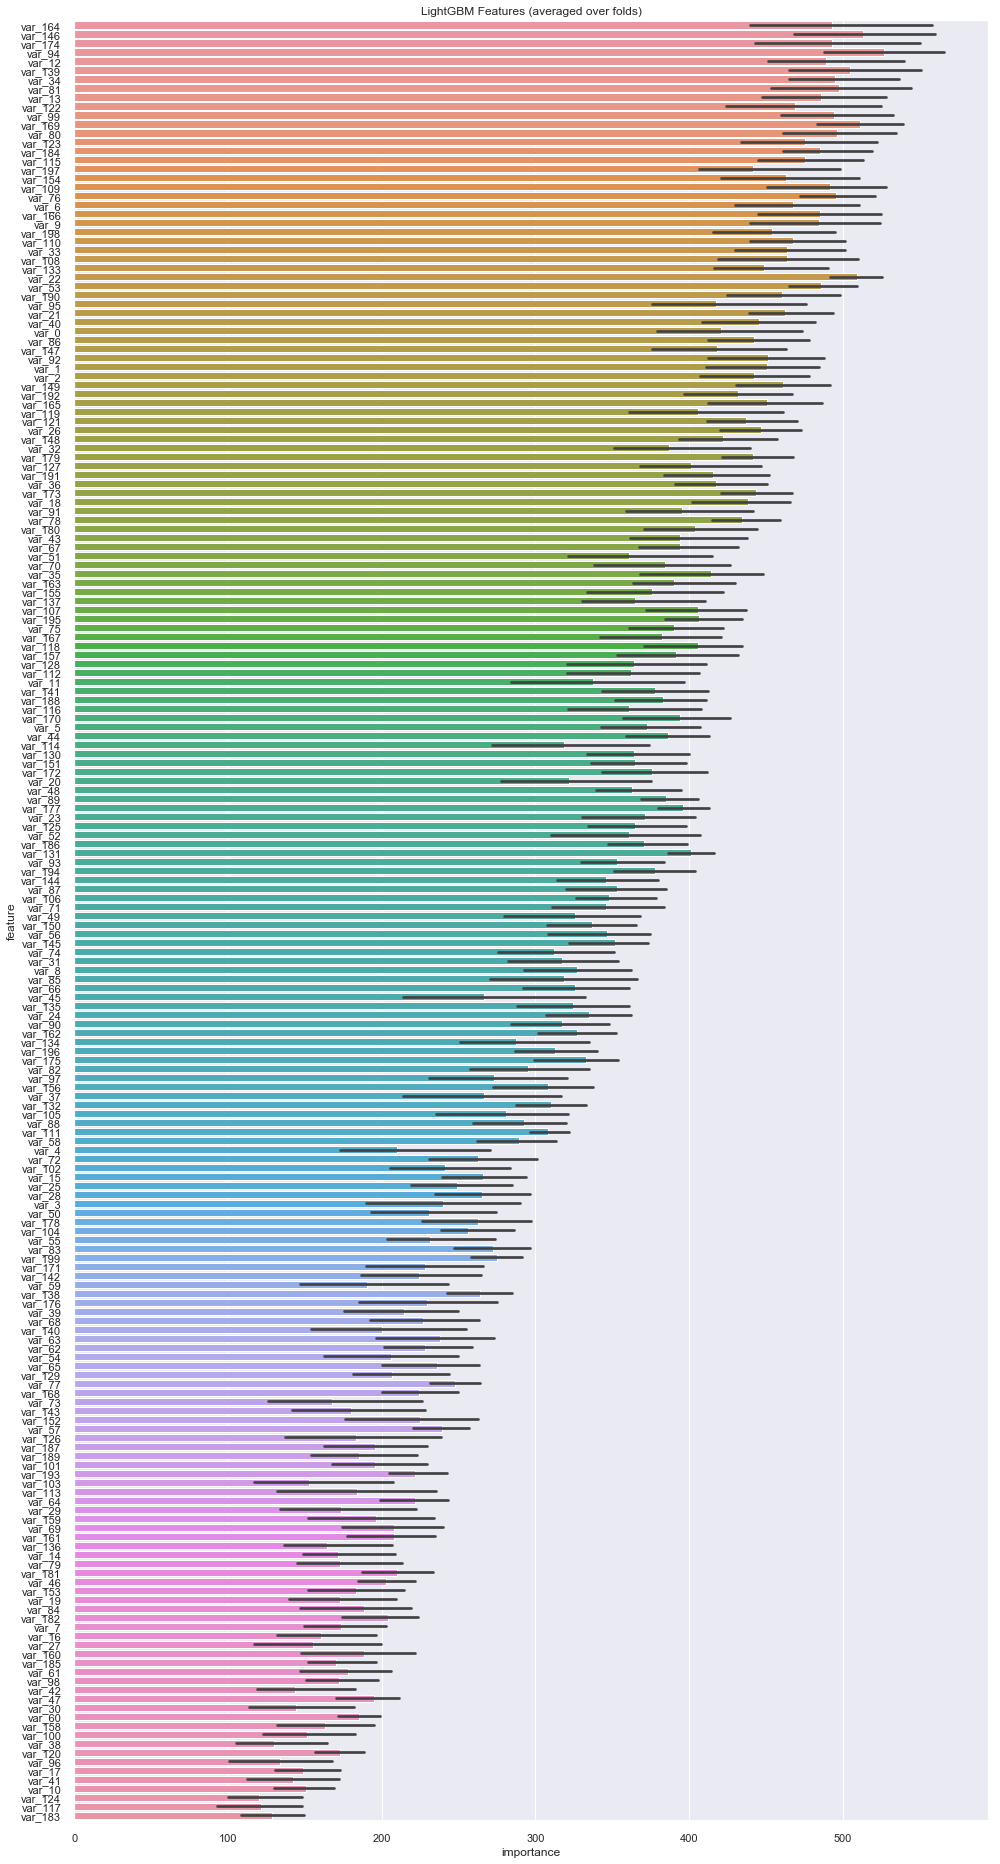

In [42]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [43]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)
oof.to_csv('lgb_oof.csv', index=False)
